<h1 style='text-align:center'>Python Intro to Image Data Reduction </h1>

<br>
<strong>
    TF: Maurice Wilson<br>
    Astron 100 Section<br>
    Spring 2021
</strong>

In IRAF, you "combined" bias and flat files.  You also used "imarith" to divide some images by a number.  Let's do something similar with Python.

For this exercise, we can use the same images from our remote computers.

scp \<username\>@3.231.34.76:~/exercise1/grb050318.tar .

tar -xv -f grb050318.tar

To handle the many files, let's use a package that can easily access all of these files from our directory.

In [1]:
import glob

fileNamesList = glob.glob('ccd0*fits')  # make a list of filenames using UNIX syntax

print(fileNamesList)

['ccd032.fits', 'ccd033.fits', 'ccd034.fits', 'ccd035.fits', 'ccd036.fits', 'ccd037.fits', 'ccd038.fits', 'ccd039.fits', 'ccd040.fits', 'ccd041.fits', 'ccd042.fits', 'ccd043.fits', 'ccd044.fits', 'ccd045.fits', 'ccd046.fits', 'ccd047.fits', 'ccd048.fits', 'ccd058.fits', 'ccd059.fits', 'ccd060.fits', 'ccd061.fits']


Let's use the same astropy package as last time to access the information and data of the FITS files.

In [16]:
from astropy.io import fits

#
# make a list of primary data-header units
#
phdu_list = []  # empty list that will hold all FITS files  
for fn_index, fn in enumerate( fileNamesList ):
    
    hdu = fits.open( fn )
    phdu_list.append( hdu[0]  )
    
    print( fn_index, fn, hdu[0].header['object']  )


    

0 ccd032.fits Bias
1 ccd033.fits Bias
2 ccd034.fits Bias
3 ccd035.fits Bias
4 ccd036.fits Bias
5 ccd037.fits Bias
6 ccd038.fits Bias
7 ccd039.fits Bias
8 ccd040.fits Bias
9 ccd041.fits Bias
10 ccd042.fits Dome Flat
11 ccd043.fits Dome Flat
12 ccd044.fits Dome Flat
13 ccd045.fits Dome Flat
14 ccd046.fits Dome Flat
15 ccd047.fits Dome Flat
16 ccd048.fits Dome Flat
17 ccd058.fits GRB050318
18 ccd059.fits GRB050318
19 ccd060.fits GRB050318
20 ccd061.fits GRB050318


As you can see, we have 21 files.  Let's look at a specific bias file first.

754.0


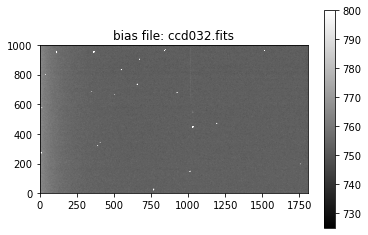

In [17]:
import numpy as np
import matplotlib.pyplot as plt


hdu_data = fits.open('ccd032.fits')[0].data

# there are some "hot pixels" so for the sake of plotting, 
# let's find out where a decent upper limit should be around for the sake of contrast in the image
print( np.median(hdu_data) ) 


fig, axp = plt.subplots()

imageax = axp.imshow( hdu_data ,  origin='lower', cmap='gray', vmax=800 )  # vmax is the upper limit for the contrast

axp.set_title(f'bias file: ccd032.fits')
fig.colorbar( imageax, ax=axp)

plt.show()
plt.close()

Let's show a flat and a science image, just to see what we're working with.

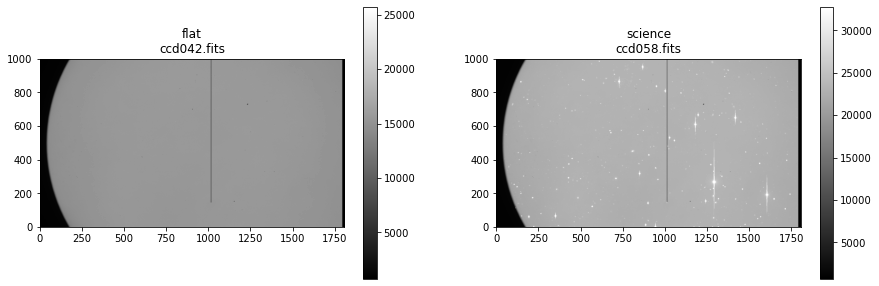

In [18]:
flat = phdu_list[ 10 ]
flatdata = flat.data

sci = phdu_list[ 17 ]
scidata = sci.data


fig, axs = plt.subplots(1, 2, figsize=(15,5) )

imageax = axs[0].imshow( flatdata  , origin='lower', cmap='gray')
axs[0].set_title( 'flat\n'+ fileNamesList[ 10 ] )
fig.colorbar( imageax, ax=axs[0] )

imageax = axs[1].imshow( scidata , origin='lower', cmap='gray')
axs[1].set_title( 'science\n'+ fileNamesList[ 17 ] )
fig.colorbar( imageax, ax=axs[1] )

plt.show()
plt.close()

As you can see, to the far right of both images are the overscan regions.  Let's find that region and "trim" the image.

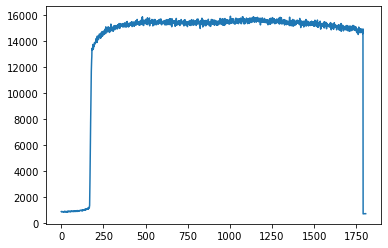

In [31]:
# 
# take a slice across all columns of a single row to quickly discern the overscan region
#
plt.figure()
plt.plot( flatdata[ 0 , : ])  # the very lowest row will be plotted
plt.show()
plt.close()

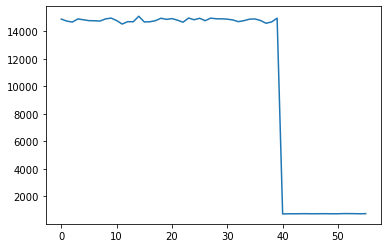

In [32]:
# zoom in on the overscan region
plt.plot( flatdata[ 0 , 1750: ]) 

It seems that the region starts at about column 1790. So later, we'll "trim" the images from that column onward to the right of the images.




Similar to what we did in IRAF, let's "combine" the bias files in a simplified way.

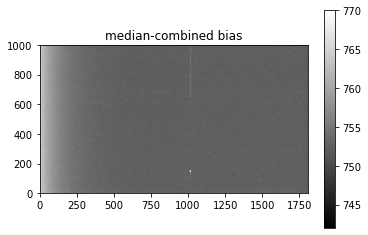

final bias:  avg=753, median=753, st.dev.=3


In [33]:

# get each bias data array nested into a larger array.
bias_datasets = np.array([  onebias.data  for onebias in phdu_list[0:10]  ])


# let's median-combine the biases to get a final bias
# take the median per pixel across all images

biasfinal = np.median( bias_datasets, axis=0 )


# take a look at the image
fig, axp = plt.subplots()

imageax = axp.imshow(  biasfinal ,  origin='lower', cmap='gray', vmax=770 )  
axp.set_title(f'median-combined bias')
fig.colorbar( imageax, ax=axp)

plt.show()
plt.close()

print(f"final bias:  avg={np.mean(biasfinal):.0f}, median={np.median(biasfinal):.0f}, st.dev.={np.std(biasfinal):.0f}")

Obviously, this is not a great bias image, but we won't bother with handling bad pixels during this exercise.

Let's subtract this bias from each flat image.

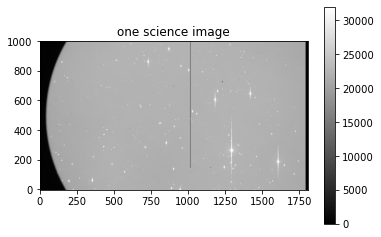

In [46]:
# get all flat images into one variable 
# subtract final bias image from each flat image, simultaneously


b_flat_datasets = np.array([ flat_phdu.data - biasfinal  for flat_phdu in phdu_list[10:17]  ])  # all flats are debiased


# do the same for the science images
b_sci_datasets = np.array([ sci_phdu.data - biasfinal  for sci_phdu in phdu_list[17:21]  ])



# take a look at a science image
fig, axp = plt.subplots()

imageax = axp.imshow(  b_sci_datasets[0] ,  origin='lower', cmap='gray' )  
axp.set_title(f'one science image')
fig.colorbar( imageax, ax=axp)

plt.show()
plt.close()


Let's "combine" the flatfield images and divide that final image into the science images.